In [1]:
! pip install python-gdcm
! pip install pylibjpeg pylibjpeg-libjpeg pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 10.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom as dcm
import os
import nibabel as nib
import SimpleITK as sitk
from tqdm import tqdm
from tensorflow import keras
from keras import layers, models
import tensorflow_io as tfio
import cv2
import warnings
warnings.filterwarnings('ignore')
from skimage.transform import resize
from tqdm import tqdm
import tensorflow_addons as tfa

In [3]:
def load_image(path):
    img = dcm.read_file(path)
    img = img.pixel_array
    return cv2.resize(img, (256,256))

In [4]:
 def window_image(img, minn,maxx, intercept, slope, rescale=True):
    img = (img*slope +intercept) 
    img[img<minn] = minn 
    img[img>maxx] = maxx 
    if rescale: 
        img = (img - minn) / (maxx - minn)
    return img
    
def get_first_of_dicom_field_as_int(x):
    if type(x) == dcm.multival.MultiValue: return int(x[0])
    else: return int(x)
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value,
                    data[('0028','1051')].value,
                    data[('0028','1052')].value,
                    data[('0028','1053')].value]
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [5]:
def channeling(img,img1,img2):
    return np.stack([img, img1, img2], axis=-1)

In [6]:
bb_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")


In [7]:
df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
df = df[df['patient_overall']==0]


In [8]:
a_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
a_df = a_df.set_index(a_df['StudyInstanceUID'])


In [9]:
path = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/"

In [10]:
import random

def my_distribution(maxx):
    THRESHOLD = [0.05, 0.95]
    u = random.random()
    if u <= THRESHOLD[0]:
        return random.randint(1, maxx//5)
    elif u <= THRESHOLD[1]:
        return random.randint( (maxx//5),  ((4*maxx)//5))
    else:
        return random.randint(((4*maxx)//5), maxx)

In [11]:
t = 3
n_all = t*7217
n_80 = ((t*7217)*(8))//10
deviation = n_all//1058 
np_list = np.arange(n_all)
random_list = np.random.choice(np_list,n_all,replace=False)

def data_gen():
    for i in random_list[:n_80]:
        if i%t!=0:
            try:
                data = dcm.dcmread(path+df.iloc[i//int(deviation)]["StudyInstanceUID"]+"/"+str(my_distribution(len(os.listdir(path+df.iloc[i//int(deviation)]["StudyInstanceUID"]))))+".dcm")
                window_center , window_width, intercept, slope = get_windowing(data)
                img = load_image(path+df.iloc[i//int(deviation)]["StudyInstanceUID"]+"/"+str(my_distribution(len(os.listdir(path+df.iloc[i//int(deviation)]["StudyInstanceUID"]))))+".dcm")
                img1 = window_image(img, 100, 600, intercept, slope, rescale = True)
                img2 = window_image(img, 600, 1100, intercept, slope, rescale = True)
                img3 = window_image(img, 1100, 1600, intercept, slope, rescale = True)
                yield ({"input_1": channeling(img1,img2, img3)},
                {'co': 0},
                {'co': 1})
            except:
                continue

        else:    
            data = dcm.dcmread(path+bb_df.iloc[i//t]["StudyInstanceUID"]+"/"+str(bb_df.iloc[i//t]["slice_number"])+".dcm")
            window_center , window_width, intercept, slope = get_windowing(data)
            img = load_image(path+bb_df.iloc[i//t]["StudyInstanceUID"]+"/"+str(bb_df.iloc[i//t]["slice_number"])+".dcm")
            img1 = window_image(img, 100, 600, intercept, slope, rescale = True)
            img2 = window_image(img, 600, 1100, intercept, slope, rescale = True)
            img3 = window_image(img, 1100, 1600, intercept, slope, rescale = True)
            yield ({"input_1": channeling(img1,img2, img3)},
            {'co': 1},
            {'co': 2})
        
        
def test_gen():
    for i in random_list[n_80:]:
        if i%t!=0:
            try:
                data = dcm.dcmread(path+df.iloc[i//int(deviation)]["StudyInstanceUID"]+"/"+str(my_distribution(len(os.listdir(path+df.iloc[i//int(deviation)]["StudyInstanceUID"]))))+".dcm")
                window_center , window_width, intercept, slope = get_windowing(data)
                img = load_image(path+df.iloc[i//int(deviation)]["StudyInstanceUID"]+"/"+str(my_distribution(len(os.listdir(path+df.iloc[i//int(deviation)]["StudyInstanceUID"]))))+".dcm")
                img1 = window_image(img, 100, 600, intercept, slope, rescale = True)
                img2 = window_image(img, 600, 1100, intercept, slope, rescale = True)
                img3 = window_image(img, 1100, 1600, intercept, slope, rescale = True)
                yield ({"input_1": channeling(img1,img2, img3)},
                    {'co': 0},
                    {'co': 1})
            except:
                continue

        else:    
            data = dcm.dcmread(path+bb_df.iloc[i//t]["StudyInstanceUID"]+"/"+str(bb_df.iloc[i//t]["slice_number"])+".dcm")
            window_center , window_width, intercept, slope = get_windowing(data)
            img = load_image(path+bb_df.iloc[i//t]["StudyInstanceUID"]+"/"+str(bb_df.iloc[i//t]["slice_number"])+".dcm")
            img1 = window_image(img, 100, 600, intercept, slope, rescale = True)
            img2 = window_image(img, 600, 1100, intercept, slope, rescale = True)
            img3 = window_image(img, 1100, 1600, intercept, slope, rescale = True)
            yield ({"input_1": channeling(img1,img2, img3)},
                {'co': 1},
                {'co': 2})

#  a_df.loc[bb_df.iloc[int(i//t)]["StudyInstanceUID"]]["patient_overall"] if you want multiple outputs

In [12]:
dataset = tf.data.Dataset.from_generator(
     data_gen,
     ({"input_1":tf.float32}, 
     {'co':tf.int8},
     {'co':tf.int8}),
    ({"input_1":tf.TensorShape([256,256,3])}, 
     {"co": tf.TensorShape([])},
    {"co": tf.TensorShape([])})
)

testset = tf.data.Dataset.from_generator(
     test_gen,
     ({"input_1":tf.float32}, 
     {'co':tf.int8},
     {'co':tf.int8}),
    ({"input_1":tf.TensorShape([256,256,3])}, 
     {"co": tf.TensorShape([])},
    {"co": tf.TensorShape([])})
)

2022-10-16 05:15:07.510400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 05:15:07.608659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 05:15:07.609458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 05:15:07.614898: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2022-10-16 05:15:10.288943: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Exception ignored in: <generator object data_gen at 0x7fcf6e427e50>
RuntimeError: generator ignored GeneratorExit


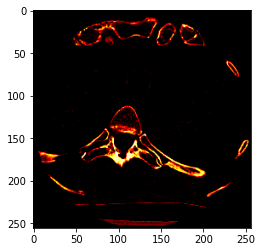

In [13]:
for i in dataset.skip(1).take(1):
    plt.imshow(i[0]['input_1'])

In [14]:
augment = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.4),
  keras.layers.GaussianNoise(0.1),
  keras.layers.RandomContrast(0.1, seed=2),
  keras.layers.RandomZoom(
    (-0.1, 0.1),
    (-0.1, 0.1),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=3)
])
    

In [15]:
dataset = dataset.map(lambda x, y, z: (augment(x['input_1']), y, z), 
              num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(20)
dataset = dataset.prefetch(1)


testset = testset.batch(50)
testset = testset.prefetch(1)

In [16]:
res = tf.keras.applications.EfficientNetB2(
    include_top=False,
    weights="imagenet",
    pooling='avg',
    input_shape=(256,256,3),
)

inputs = keras.Input((256, 256, 3), name = "input_1")
x = res(inputs)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128 ,activation = 'relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(32 ,activation = 'relu')(x)
x = keras.layers.Dropout(0.5)(x)

outputo = keras.layers.Dense(1 ,activation = 'sigmoid', name="co")(x)
                                               
model = keras.models.Model(inputs=inputs, outputs=outputo)


31801344/31790344 [==============================] - 0s 0us/step


In [17]:
def lr_schedule(epoch, lr):
    return lr/(epoch+1)

In [18]:
opt = tfa.optimizers.AdamW(
    weight_decay=2e-4,
    learning_rate = 0.001,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-07,
    name = 'AdamW',
)
loss = tf.keras.losses.BinaryCrossentropy( 
    reduction=tf.keras.losses.Reduction.AUTO,
    name='binary_crossentropy'
)
metrics = [tf.keras.metrics.AUC()]
model.compile(optimizer=opt,
              loss={"co": loss},
                metrics={"co": metrics})

In [19]:
!mkdir best_weights

In [20]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = './best_weights/model',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, 1408)              7768569   
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               180352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0     

In [22]:
history = model.fit(dataset, validation_data = testset, epochs=8, callbacks=[model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/8


2022-10-16 05:15:31.993762: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


853/853 [==============================] - 758s 864ms/step - loss: 0.9201 - auc: 0.5897 - val_loss: 1.9620 - val_auc: 0.5956
Epoch 2/8
853/853 [==============================] - 672s 788ms/step - loss: 0.8591 - auc: 0.6833 - val_loss: 0.9506 - val_auc: 0.5981
Epoch 3/8
853/853 [==============================] - 679s 797ms/step - loss: 0.8004 - auc: 0.7440 - val_loss: 0.9263 - val_auc: 0.5992
Epoch 4/8
853/853 [==============================] - 726s 851ms/step - loss: 0.7626 - auc: 0.7748 - val_loss: 0.9255 - val_auc: 0.5855
Epoch 5/8
853/853 [==============================] - 694s 813ms/step - loss: 0.7496 - auc: 0.7907 - val_loss: 0.9254 - val_auc: 0.5719
Epoch 6/8
853/853 [==============================] - 695s 815ms/step - loss: 0.7837 - auc: 0.7820 - val_loss: 0.9265 - val_auc: 0.5437
Epoch 7/8
853/853 [==============================] - 688s 806ms/step - loss: 0.8381 - auc: 0.7573 - val_loss: 0.9274 - val_auc: 0.5217
Epoch 8/8
853/853 [==============================] - 707s 828ms/s

In [23]:
!mkdir final_model

In [24]:
model.load_weights('./best_weights/model').expect_partial()
model.save("./final_model/model")

2022-10-16 06:53:33.509743: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [25]:
!mkdir feature_extractor

In [26]:
res.save('./feature_extractor')